# Image Preprocessing

The purpose of this notebook is to convert the images, given in DICOM format, which is not optimal for feeding to a CNN, to jpg files.

Once this is done, the images will be randomly separated into different files for train and validation, both with the non-opacity/non-pneumonia (labeled here as 'normal', although the images need not be normal, they just do not have pneumonia) and with the pneumonia subgroup.

For this purpose, the csv dataset is loaded. Then, using sklearn `train_test_split` two dataframes are randomly created, stratifying by Target to mantain the proportion of opacity vs non-opacity in both subsets. Using those subsets, the files are moved to its corresponding subfolders:
    - Train non-opacity.
    - Train opacity.
    - Test non-opacity.
    - Test opacity.


- *CXR: Chest X-Ray.*

##  Imports

### Libraries 

In [1]:
# System and file management
import os
import zipfile
import shutil

# General imports
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

# sklearn imports
from sklearn.model_selection import train_test_split

# DICOM
import pydicom
from pydicom.filereader import dcmread

### Functions

In [14]:
def subfolder_creator(path):
    """
    This function checks wether a folder exist. In case it does not, it creates it.
    """
    if os.path.exists(path):
        path
    else:
        os.mkdir(path)
        

def data_split(examples, labels, train_frac, random_state=None, stratify=None):
    ''' https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
    param data:       Data to be split
    param train_frac: Ratio of train set to whole dataset

    Randomly split dataset, based on these ratios:
        'train': train_frac
        'valid': (1-train_frac) / 2
        'test':  (1-train_frac) / 2

    Eg: passing train_frac=0.8 gives a 80% / 10% / 10% split
    '''

    assert train_frac >= 0 and train_frac <= 1, "Invalid training set fraction"

    X_train, X_tmp, Y_train, Y_tmp = train_test_split(examples, 
                                                      labels, 
                                                      train_size=train_frac, 
                                                      random_state=random_state,
                                                      stratify=stratify)

    X_val, X_test, Y_val, Y_test   = train_test_split(
                                        X_tmp, Y_tmp, train_size=0.5, random_state=random_state)

    return X_train, X_val, X_test,  Y_train, Y_val, Y_test

        
        
def dcm_to_img(origin_fpath, destination_fpath, PNG=False):
    """
    This function extracts the image information from DICOM (.dcm) files
    and converts it to either .png or .jpg files, saving it in the desired folder
    Inputs:
        - origin_fpath: path where the .dcm files are located.
        - destination_fpath: desired output path of the converted images.
        - PNG: default False. Wether you want the output files in .png (set as True) or .jpg format.
    Outputs:
        - Converted files, either to *.png or *.jpg.
    """
    
    images_path = os.listdir(origin_fpath) # List of files inside origin folder
    
    for n, image in enumerate(images_path):
        ds = pydicom.dcmread(os.path.join(origin_fpath, image))
        pixel_array_numpy = ds.pixel_array
        if PNG == False:
            image = image.replace('.dcm', '.jpg')
        else:
            image = image.replace('.dcm', '.png')
        cv2.imwrite(os.path.join(destination_fpath, image), pixel_array_numpy)
        if n % 1000 == 0:
            print('{} images converted'.format(n)) # Counter for every 1000 images converted
            
            
            

def target_extractor_2(origin_fpath, dataframe, dicom=False):
    """
    This function returns two lists of files, one with the normal xrays and another one with the pneumonia xrays, and prints the total number of files in each group.
    Inputs:
        - file_path: the path of the folder containing the dicom images.
        - dataframe: the dataframe over which you want to iterate to separate both classes.
        - dicom (default False): wether the file_path contains DICOM (set to True) or JPG files.
    Outputs:
        - List containing non-opacity X-rays.
        - List containing opacity X-rays.
    """
    normalcxr = []; pneumoniacxr = []
    if dicom == True:
        for i in os.listdir(origin_fpath):
            if i in list(dataframe.dcm_file_name.loc[dataframe.target == 1]):
                pneumoniacxr.append(i) 
            elif i in list(dataframe.dcm_file_name.loc[dataframe.target == 0]):
                normalcxr.append(i)
            else:
                pass
            
    if dicom == False:
        for i in os.listdir(origin_fpath):
            if i in list(dataframe.jpg_file_name.loc[dataframe.target == 1]):
                pneumoniacxr.append(i) 
            elif i in list(dataframe.jpg_file_name.loc[dataframe.target == 0]):
                normalcxr.append(i)
            else:
                pass
        
    return (normalcxr, pneumoniacxr)


def target_extractor_3(origin_fpath, dataframe, dicom=False):
    """
    This function returns two lists of files, one with the normal xrays and another one with the pneumonia xrays, and prints the total number of files in each group.
    Inputs:
        - file_path: the path of the folder containing the dicom images.
        - dataframe: the dataframe over which you want to iterate to separate both classes.
        - dicom (default False): wether the file_path contains DICOM (set to True) or JPG files.
    Outputs:
        - List containing normal X-rays.
        - List containing non-normal/non-pneumonia X-rays.
        - List containing Pnuemonia X-rays.
    """
    normalcxr = []; nnnpcxr = []; pneumoniacxr = []
    if dicom == True:
        for i in os.listdir(origin_fpath):
            if i in list(dataframe.dcm_file_name.loc[dataframe.type == 'Lung Opacity']):
                pneumoniacxr.append(i)
            elif i in list(dataframe.dcm_file_name.loc[dataframe.type == 'No Lung Opacity / Not Normal']):
                nnnpcxr.append(i)
            elif i in list(dataframe.dcm_file_name.loc[dataframe.type == 'Normal']):
                normalcxr.append(i)
            else:
                pass
            
    if dicom == False:
        for i in os.listdir(origin_fpath):
            if i in list(dataframe.jpg_file_name.loc[dataframe.type == 'Lung Opacity']):
                pneumoniacxr.append(i)
            elif i in list(dataframe.jpg_file_name.loc[dataframe.type == 'No Lung Opacity / Not Normal']):
                nnnpcxr.append(i)
            elif i in list(dataframe.jpg_file_name.loc[dataframe.type == 'Normal']):
                normalcxr.append(i)
            else:
                pass
        
    return (normalcxr, nnnpcxr, pneumoniacxr)



            
def copy_files(origin_fpath, destination_fpath, file_list):
    """
    This function checks if the directories exists then moves the files whose names are contained 
    in the list to the desired destination directory.
    Inputs:
        - origin_fpath: path of origin of the files.
        - destination_fpath: desired destination path.
        - file_list: the list of names of the files that are to be moved.
    Outputs:
        - No outputs displayed.
    """
    # Check if both the are directories
    if os.path.isdir(origin_fpath) and os.path.isdir(destination_fpath) :
        # Iterate over all the files in a list, that we know are located in the source directory
        for file in file_list:
            # Define the route:
            file_path = os.path.join(origin_fpath, file)
            # Move each file to destination Directory
            shutil.copy(file_path, destination_fpath);
    else:
        print("origin_fpath & destination_fpath should be Directories")
        
        

        
def zip_creator(fname_list, origin_fpath, destination_fpath, file_name='default.zip'):
    """
    This function exports a .zip file containing the files whose names are in a provided list.
    Inputs:
        - fname_list: list containing the names of the files to be compressed.
        - origin_fpath: path where the origin files are located.
        - destination_fpath: path where the created .zip will be exported.
        - file_name: desired name of the .zip file.
    Outputs:
        - .zip file containing the original images.
    """
    compressed = zipfile.ZipFile(os.path.join(destination_fpath, file_name), 'w')
    for file in fname_list:
        img_path = os.path.join(origin_fpath, file)
        compressed.write(img_path)
    compressed.close()

### Paths and constants

In [3]:
PATH = 'data/' # root
CSV_PATH = os.path.join(PATH,'csv') # folder with csv datasets
DICOM_PATH = os.path.join(PATH, 'pool') # folder containing all of the dicom files
JPG_PATH = os.path.join(PATH, 'pool_jpg') # folder containing all the converted jpg files
DESTINATION_PATH = os.path.join(PATH, 'sorted_3') # Folder where the train and test subsets will be located

# Train folder
TRAIN_PATH = os.path.join(DESTINATION_PATH, 'train')
TRAIN_NORMAL_PATH = os.path.join(TRAIN_PATH, 'normal')
TRAIN_NNNP_PATH = os.path.join(TRAIN_PATH, 'nnnp')
TRAIN_PNEUMONIA_PATH = os.path.join(TRAIN_PATH, 'pneumonia')

# Validation folder
VAL_PATH = os.path.join(DESTINATION_PATH, 'validation')
VAL_NORMAL_PATH = os.path.join(VAL_PATH, 'normal')
VAL_NNNP_PATH = os.path.join(VAL_PATH, 'nnnp')
VAL_PNEUMONIA_PATH = os.path.join(VAL_PATH, 'pneumonia')

# Test folder
TEST_PATH = os.path.join(DESTINATION_PATH, 'test')
TEST_NORMAL_PATH = os.path.join(TEST_PATH, 'normal') 
TEST_NNNP_PATH = os.path.join(TEST_PATH, 'nnnp')
TEST_PNEUMONIA_PATH = os.path.join(TEST_PATH, 'pneumonia') 

### CSV import

The clean csv file created in the previous step is loaded:

In [4]:
labels = pd.read_csv(os.path.join(CSV_PATH,'cxr_information.csv'))
labels.head()

,patient_id,dcm_file_name,jpg_file_name,type,sex,age,view,target,target_3,type_0,type_1,type_2
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm,0004cfab-14fd-4e49-80ba-63a80b6bddd6.jpg,No Lung Opacity / Not Normal,F,51,PA,0,1,0,1,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,00313ee0-9eaa-42f4-b0ab-c148ed3241cd.dcm,00313ee0-9eaa-42f4-b0ab-c148ed3241cd.jpg,No Lung Opacity / Not Normal,F,48,PA,0,1,0,1,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,00322d4d-1c29-4943-afc9-b6754be640eb.dcm,00322d4d-1c29-4943-afc9-b6754be640eb.jpg,No Lung Opacity / Not Normal,M,19,AP,0,1,0,1,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,003d8fa0-6bf1-40ed-b54c-ac657f8495c5.dcm,003d8fa0-6bf1-40ed-b54c-ac657f8495c5.jpg,Normal,M,28,PA,0,0,1,0,0
4,00436515-870c-4b36-a041-de91049b9ab4,00436515-870c-4b36-a041-de91049b9ab4.dcm,00436515-870c-4b36-a041-de91049b9ab4.jpg,Lung Opacity,F,32,AP,1,2,0,0,1


##  train-validation-test split

In [5]:
X_train, X_val, X_test, y_train, y_val, y_test = data_split(labels.drop(columns = ['target_3']), labels.target_3, train_frac=0.7, random_state=18, stratify=labels.target_3)

In [6]:
train_df = pd.concat([X_train, y_train], axis=1)
train_df.to_csv(os.path.join(CSV_PATH,'train_df.csv'), index=False)

In [7]:
val_df = pd.concat([X_val, y_val], axis=1)
val_df.to_csv(os.path.join(CSV_PATH,'val_df.csv'), index=False)

In [8]:
test_df = pd.concat([X_test, y_test], axis=1)
test_df.to_csv(os.path.join(CSV_PATH,'test_df.csv'), index=False)

### Distribution of Type variable in Train, Validation and Test Subsets

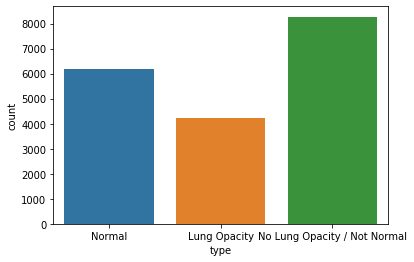

In [9]:
sns.countplot(x = 'type', data = train_df)

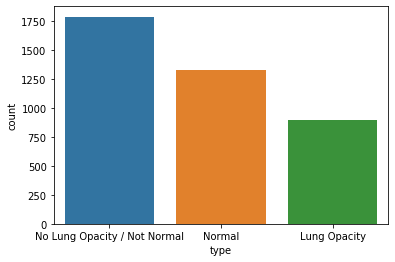

In [10]:
sns.countplot(x = 'type', data = val_df)

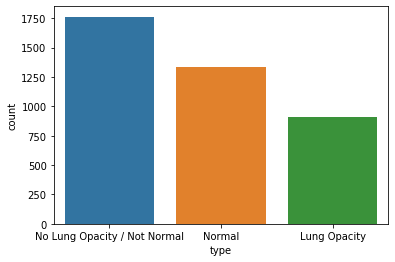

In [11]:
sns.countplot(x = 'type', data = test_df)

## Decompress files

In [12]:
# Creating directory:
subfolder_creator(DICOM_PATH)

# Extracting the dicom files into directory:
local_zip = os.path.join(PATH, 'all_images.zip')
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall(DICOM_PATH)
zip_ref.close()

## Convert .dcm files to .jpg

In [13]:
# Creating directory:
subfolder_creator(JPG_PATH)

# Converting .dcm to .jpg:
dcm_to_img(origin_fpath=DICOM_PATH,
           destination_fpath=JPG_PATH,
           PNG=False)

0 images converted
1000 images converted
2000 images converted
3000 images converted
4000 images converted
5000 images converted
6000 images converted
7000 images converted
8000 images converted
9000 images converted
10000 images converted
11000 images converted
12000 images converted
13000 images converted
14000 images converted
15000 images converted
16000 images converted
17000 images converted
18000 images converted
19000 images converted
20000 images converted
21000 images converted
22000 images converted
23000 images converted
24000 images converted
25000 images converted
26000 images converted


## Separating Normal, Not-Normal/Not-Pneumonia (NNNP) and Pneumonia CXR for each subset

Using the `target_extractor_3` function defined above, three lists containing the names of images with pneumonia, not-normal/not-pneumonia and normal are created.

A short line is run afterwards to check that the number of total X-Rays is the same as the number of files in desired path.

In [15]:
train_normal_files, train_nnnp_files, train_pneumonia_files = target_extractor_3(JPG_PATH, train_df)

In [17]:
val_normal_files, val_nnnp_files, val_pneumonia_files = target_extractor_3(JPG_PATH, val_df)

In [18]:
test_normal_files, test_nnnp_files, test_pneumonia_files = target_extractor_3(JPG_PATH, test_df)

In [19]:
print('Normal train X-rays:{}\nNNNP train X-rays:{}\nPneumonia train X-rays:{}'.format(len(train_normal_files), 
                                                                                       len(train_nnnp_files), 
                                                                                       len(train_pneumonia_files)))
      
print('Normal validation X-rays:{}\nNNNP validation X-rays:{}\nPneumonia validation X-rays:{}'.format(len(val_normal_files), 
                                                                                                      len(val_nnnp_files), 
                                                                                                      len(val_pneumonia_files)))

print('Normal test X-rays:{}\nNNNP test X-rays:{}\nPneumonia test X-rays:{}'.format(len(test_normal_files), 
                                                                                    len(test_nnnp_files), 
                                                                                    len(test_pneumonia_files)))

total = len((train_normal_files + train_nnnp_files + train_pneumonia_files + val_normal_files + val_nnnp_files + val_pneumonia_files + test_normal_files + test_nnnp_files + test_pneumonia_files))
print('Total files in list: {}'.format(total))


print('======\nTotal files in original path:{}'.format(len(os.listdir(JPG_PATH))))

Normal train X-rays:6196
NNNP train X-rays:8274
Pneumonia train X-rays:4208
Normal validation X-rays:1323
NNNP validation X-rays:1784
Pneumonia validation X-rays:896
Normal test X-rays:1332
NNNP test X-rays:1763
Pneumonia test X-rays:908
Total files in list: 26684
Total files in original path:26684


## Creating sub-folder structure and moving the images to their corresponding subset:

Checking that the subfolders are created, if not, create them:

In [20]:
for folder in [DESTINATION_PATH, 
               TRAIN_PATH, 
               VAL_PATH,
               TEST_PATH, 
               TRAIN_NORMAL_PATH, 
               TRAIN_PNEUMONIA_PATH,
               TRAIN_NNNP_PATH,
               VAL_NORMAL_PATH,
               VAL_NNNP_PATH,
               VAL_PNEUMONIA_PATH,
               TEST_NORMAL_PATH,
               TEST_NNNP_PATH,
               TEST_PNEUMONIA_PATH]:
    subfolder_creator(folder)

Looping over the lists and the desired destination files to move files using `move_files` function defined above:

In [21]:
len(os.listdir(JPG_PATH))

26684

In [22]:
var = [train_normal_files, train_nnnp_files, train_pneumonia_files, val_normal_files, val_nnnp_files, val_pneumonia_files, test_normal_files, test_nnnp_files, test_pneumonia_files]
path = [TRAIN_NORMAL_PATH, TRAIN_NNNP_PATH, TRAIN_PNEUMONIA_PATH, VAL_NORMAL_PATH, VAL_NNNP_PATH, VAL_PNEUMONIA_PATH, TEST_NORMAL_PATH, TEST_NNNP_PATH, TEST_PNEUMONIA_PATH]

for a,b in zip(var,path):
    copy_files(origin_fpath=JPG_PATH,
               destination_fpath=b, 
               file_list=a)

## Conclusion 

The result of runing this notebook should be the creation of a **sorted_3** folder containing three subfolders, **train**, **validation**, and **test** each one containing three subclasses of images, *normal*, *not-normal/not-pneumonia (nnnp)* and *pneumonia*.